In [46]:
# I: Standard library imports
import os
import warnings

# II: Third-party imports

# II.A: General utilities
import holidays
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# II.B: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# III: Machine learning

# III.A: Scikit-learn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, BaseCrossValidator, ParameterGrid
from sklearn.preprocessing import StandardScaler

# III.B: TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, Dense, Dropout, Flatten, Input, Lambda, LSTM, MaxPooling1D
)
from tensorflow.keras.models import Model

# III.C: XGBoost
from xgboost import XGBRegressor

# III.D: Time-series specific models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# IV: Local imports
from pauls_data_loaders import loader_functions as lf

# V: Global config options

# Silence TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Pandas display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Suppress warnings
warnings.filterwarnings("ignore")


# Helper Functions

## Feature Engineering

In [97]:
def fixed_set_description(pbar, description, width=70):
    pbar.set_description(description.ljust(width))

def add_lag_features(df, column, lags, pbar):
    for lag in lags:
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)
        pbar.update(1)
    return df

def add_rolling_avg_features(df, column, windows, pbar):
    for window in windows:
        df[f"{column}_rolling_avg_{window}"] = df[column].rolling(window).mean()
        pbar.update(1)
    df.fillna(0, inplace=True)
    return df

def add_time_features(df, pbar):
    """
    Adds time-based features to the dataframe based on the index (assumed to be datetime).
    Parameters:
        df (pd.DataFrame): The input dataframe.
    Returns:
        pd.DataFrame: The dataframe with time-based features added.
    """
    # Ensure the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("Index must be of datetime type")
    
    # Extracting features from datetime index
    df['hour'] = df.index.hour  # Hour of the day
    pbar.update(1)
    df['day_of_week'] = df.index.dayofweek  # Day of the week (0 = Monday, 6 = Sunday)
    pbar.update(1)
    df['month'] = df.index.month  # Month (1 = January, 12 = December)
    pbar.update(1)
    df['quarter'] = df.index.quarter  # Quarter of the year (1-4)
    pbar.update(1)
    df['year'] = df.index.year  # Year
    pbar.update(1)

    return df

In [76]:
def add_engineered_features(df, config, pbar, standardize_columns=None):
    """
    Adds engineered features, holiday flags, and standardizes specified columns.
    Assumes that datetime is always the index column.
    Parameters:
        df (pd.DataFrame): The input dataframe.
        config (dict): Configuration dictionary with feature parameters.
        standardize_columns (list): List of columns to standardize.
    Returns:
        pd.DataFrame: The dataframe with standardized columns and engineered features.
    """
    # Calculate extra tasks
    fixed_set_description(pbar, 'Engineering Features')
    
    # Standardize specified columns
    if standardize_columns:
        fixed_set_description(pbar, 'Engineering Features: Standardizing Columns')
        scaler = StandardScaler()
        df[standardize_columns] = scaler.fit_transform(df[standardize_columns])
        pbar.update(1)        

    # Add lag features
    if "lag" in config:
        fixed_set_description(pbar, 'Engineering Features: Adding Lag Columns')
        for col, lags in config["lag"].items():
            fixed_set_description(pbar, f'Engineering Features: Adding Lag Columns: {col}')
            df = add_lag_features(df, col, lags, pbar)

    # Add rolling averages
    if "rolling_avg" in config:
        fixed_set_description(pbar, 'Engineering Features: Adding Rolling Average Columns')
        for col, windows in config["rolling_avg"].items():
            fixed_set_description(pbar, f'Engineering Features: Adding Rolling Average Columns: {col}')
            df = add_rolling_avg_features(df, col, windows, pbar)

    # Add time features if the flag is True
    if config.get("add_time_features", False):
        fixed_set_description(pbar, 'Engineering Features: Adding Rolling Average Columns')
        df = add_time_features(df, pbar)

    return df

## Data Manager

In [5]:
class dataManager:
    def __init__(self, config={"lag": [1, 2, 3], "rolling_avg": [3, 6, 12], "add_time_features": True}):
        plain_data = lf.load_all_data()
        # List of column names
        self.stations = [f"station_{i}" for i in range(1, 12)]
        self.zones = [f"zone_{i}" for i in range(1, 21)]

        # Configuration for engineered features
        full_config = {
            "lag": {col: config["lag"] for col in self.stations},  # Lags for all station columns
            "rolling_avg": {col: config["rolling_avg"] for col in self.stations},  # Rolling averages
            "add_time_features": config["add_time_features"],  # Turn time-based features on/off
        }

        self.data = add_engineered_features(plain_data, full_config, standardize_columns=self.stations)
        self.engineereds = self.data.columns.difference(self.stations + self.zones).tolist()
    
    def out_data(self, zone=None, plain=False):
        return_cols = self.stations
        if zone == None:
            return_cols = self.zones + return_cols
        elif isinstance(zone, str):
            return_cols = zone + return_cols
        elif isinstance(zone, int):
            return_cols = [f'zone_{zone}'] + return_cols
        else:
            raise TypeError
        if not plain:
            return_cols += self.engineereds
        return self.data[return_cols]

## Preprocessers

In [59]:
def create_sequences(data, sequence_length):  # For LSTM CNN
    # Get the total number of sequences
    num_sequences = len(data) - sequence_length
    
    # Pre-allocate arrays for X and y
    X = np.empty((num_sequences, sequence_length, data.shape[1] - 1))  # Exclude response column
    y = np.empty(num_sequences)
    
    # Fill in the X and y arrays
    with tqdm(total=num_sequences, desc=f'Slicing Sequences of Length {sequence_length} 💅🔪', colour='purple') as pbar:
        for i in range(num_sequences):
            X[i] = data.iloc[i:i + sequence_length, 1:].values  # Predictors
            y[i] = data.iloc[i + sequence_length, 0]  # Response
            pbar.update(1)
    
    return X, y

# Model Functions

In [62]:
def lstm_cnn(sequence_length, feature_dim):
    # define shape of input
    input_shape = (sequence_length, feature_dim)
    
    # construct input layer
    inputs = Input(shape=input_shape)

    # construct CNN layers
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # Define a Lambda layer to reshape the CNN output for LSTM
    lstm_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(cnn)
    
    # construct LSTM layers
    lstm = LSTM(64, return_sequences=False)(lstm_input)

    # Fully connected layers
    dense = Dense(128, activation='relu')(lstm)
    dense = Dropout(0.5)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)  # For binary classification

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Return
    return model

# Cross Validation

In [77]:
# Custom expanding window splitter
class ExpandingWindowSplit(BaseCrossValidator):
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = X.shape[0]
        fold_size = n_samples // (self.n_splits + 1)
        for i in range(1, self.n_splits + 1):
            train_end = i * fold_size
            test_start = train_end
            test_end = test_start + fold_size

            train_indices = list(range(0, train_end))
            test_indices = list(range(test_start, test_end))

            yield train_indices, test_indices

    def _iter_test_indices(self, X=None, y=None, groups=None):
        n_samples = X.shape[0]
        fold_size = n_samples // (self.n_splits + 1)
        for i in range(1, self.n_splits + 1):
            test_start = i * fold_size
            test_end = test_start + fold_size
            yield range(test_start, test_end)

In [107]:
# Prepare data
d = dataManager()
data = d.out_data(1)

# Prepare the model and parameter grid
model = XGBRegressor(objective="reg:squarederror")
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "n_estimators": [50, 100, 150, 200]
}

# Define GridSearchCV with the custom cross-validator
cv = ExpandingWindowSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring="neg_root_mean_squared_error", verbose=2)

In [ ]:
# Run GridSearch
X = data.drop(columns=["zone_1"])
y = data["zone_1"].astype(float)
grid_search.fit(X, y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

In [109]:
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.258183,0.071776,0.027140,0.001077,0.01,3,50,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-3931.778607,-4358.268534,-4248.822299,-5301.988923,-4285.224821,-4425.216637,462.040139,64
1,0.375293,0.096825,0.026897,0.000222,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-3194.403227,-3538.405771,-3424.828146,-4265.655516,-3541.984799,-3593.055492,359.224072,60
2,0.476996,0.129552,0.030612,0.003065,0.01,3,150,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-2763.687870,-3047.553706,-2952.439847,-3670.528305,-3113.790754,-3109.600097,304.257254,58
3,0.670661,0.142041,0.036325,0.002248,0.01,3,200,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-2524.113289,-2747.701128,-2647.810651,-3311.599354,-2840.464362,-2814.337757,269.945792,55
4,0.427288,0.071033,0.032305,0.001886,0.01,5,50,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-3703.243726,-4037.170863,-3966.934482,-5078.502568,-4039.777252,-4165.125778,473.065893,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2.188185,0.299092,0.045681,0.003455,0.20,7,200,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",-1893.050292,-1652.502320,-1630.379632,-1923.421571,-1627.270413,-1745.324846,133.646193,13
60,1.459452,0.211943,0.038731,0.002745,0.20,9,50,"{'learning_rate': 0.2, 'max_depth': 9, 'n_esti...",-1885.887953,-1649.770790,-1636.075941,-2014.394793,-1560.101347,-1749.246165,171.728498,19
61,2.897131,0.700630,0.044604,0.006786,0.20,9,100,"{'learning_rate': 0.2, 'max_depth': 9, 'n_esti...",-1888.718303,-1651.316388,-1636.657816,-2026.043121,-1541.532140,-1748.853554,179.710743,18
62,3.424773,0.388394,0.049104,0.006406,0.20,9,150,"{'learning_rate': 0.2, 'max_depth': 9, 'n_esti...",-1886.844899,-1652.364787,-1638.376670,-2036.857868,-1535.129304,-1749.914706,183.943331,20


In [ ]:
# Prepare data
d = dataManager()
data = d.out_data(1)

# Define the model
gbr = GradientBoostingRegressor()

# Define the parameter grid
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}

# Define scoring function (RMSE)
scorer = make_scorer(mean_squared_error, squared=False)

# Use your ExpandingWindowSplit or any cross-validator
cv = ExpandingWindowSplit(n_splits=5)

# Split Data
X = data.drop(columns=["zone_1"])
y = data["zone_1"].astype(float)

# GridSearchCV setup
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=cv, scoring=scorer, verbose=2)
grid_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", grid_search.best_score_)

In [ ]:
# Prepare data
d = dataManager()
data = d.out_data(1)

# Split Data
X = data.drop(columns=["zone_1"])
y = data["zone_1"].astype(float)

cv = ExpandingWindowSplit(n_splits=5)

# Prepare the parameter grid
param_grid = {
    "min_child_weight": [1, 3, 5],           # Minimum sum of instance weights (regularization)
    "subsample": [0.7, 0.8, 1.0],            # Fraction of samples for training each tree
    "colsample_bytree": [0.7, 0.8, 1.0],     # Fraction of features for each tree
    "gamma": [0, 0.1, 0.2],                  # Minimum loss reduction to make a split
    "reg_alpha": [0, 0.01, 0.1],             # L1 regularization (sparsity control)
    "reg_lambda": [1, 2, 5],                 # L2 regularization (ridge-style control)
}
grid = ParameterGrid(param_grid)

# Initialize tracking
best_params = None
best_score = np.inf  # RMSE should be minimized

# Custom progress bar
progress_bar = tqdm(grid, desc="Grid Search Progress", colour='pink', leave=True)

# Manual grid search loop
for params in progress_bar:
    # Update the progress bar with current params
    progress_bar.set_postfix(n_estimators=50, learning_rate=0.2, max_depth=3, params=params)

    # Configure the model with current parameters
    model = XGBRegressor(**params)

    # Cross-validation (using your custom CV splitter)
    scores = []
    for train_idx, test_idx in cv.split(X, y):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = model.predict(X.iloc[test_idx])
        scores.append(mean_squared_error(y.iloc[test_idx], preds, squared=False))
    
    # Average RMSE across folds
    avg_score = np.mean(scores)
    
    # Update best score
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

# Display results
print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

Grid Search Progress:   0%|          | 0/729 [00:00<?, ?it/s]

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.8}
Best RMSE: 1703.6925160391704


In [ ]:
# Prepare data
d = dataManager()
data = d.out_data(1)

# Define the model
gbr = XGBRegressor()

# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [5, 7],
    "min_child_weight": [1, 3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 2],
}

# Define scoring function (RMSE)
scorer = make_scorer(mean_absolute_error)

# Use your ExpandingWindowSplit or any cross-validator
cv = ExpandingWindowSplit(n_splits=5)

# Split Data
X = data.drop(columns=["zone_1"])
y = data["zone_1"].astype(float)

# GridSearchCV setup
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=cv, scoring=scorer, verbose=5)
grid_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", grid_search.best_score_)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=1406.440 total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=1305.531 total time=   0.6s
[CV 3/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=1331.836 total time=   0.6s
[CV 4/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=1520.760 total time=   0.7s
[CV 5/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=1335

In [80]:
# Custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-6):
    y_true_safe = np.maximum(np.abs(y_true), epsilon)  # Avoid dividing by 0
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# Custom WRMSE function
def wrmse(y_true, y_pred, weights):
    """
    Calculate the Weighted Root Mean Squared Error (WRMSE).

    Parameters:
        y_true (pd.Series): True target values, aligned by index.
        y_pred (pd.Series): Predicted target values, aligned by index.
        weights (pd.Series): Weights, not necessarily aligned to y_true/y_pred.

    Returns:
        float: WRMSE value.
    """
    # Ensure weights are aligned to y_true and y_pred
    aligned_weights = weights.reindex(y_true.index).fillna(0)

    # Compute squared errors
    squared_errors = (y_true - y_pred) ** 2

    # Only consider rows where weight is non-zero
    non_zero_weights = aligned_weights > 0

    # Compute WRMSE, ignore rows with zero weight
    weighted_squared_errors = aligned_weights * squared_errors
    weighted_squared_errors = weighted_squared_errors[non_zero_weights]
    total_weight = aligned_weights[non_zero_weights].sum()

    if total_weight > 0:
        wrmse_value = np.sqrt(weighted_squared_errors.sum() / total_weight)
    else:
        wrmse_value = 0  # Change from NaN to a more useful default like 0 or inf

    return wrmse_value


# load weights
weights = lf.load_weights().fillna(0)


# THIS IS THE CODE

Predicting for all zones:   0%|          | 0/1189 [00:00<?, ?it/s]

       zone           rmse          wrmse            mae          mape
0    zone_1    5054.979870   11171.894584    3126.129657  7.359698e+10
1    zone_2   40639.951072  101075.046219   24049.781471  6.820064e+11
2    zone_3   43846.119657  109084.497015   25920.847382  7.359823e+11
3    zone_4     124.846509     294.236862      75.792000  1.987578e+09
4    zone_5    2020.144845    4938.894823    1194.665446  3.253427e+10
5    zone_6   42409.371607  106492.683899   24793.156226  7.198562e+11
6    zone_7   43846.119657  109084.497015   25920.847382  7.359823e+11
7    zone_8     961.645714    2203.130647     576.547296  1.472747e+10
8    zone_9   23200.856254   38272.057888   17017.067723  2.595673e+11
9   zone_10   14312.432814   16429.244985   10071.147649  1.090403e+11
10  zone_11   27401.328491   64191.931382   16288.504744  4.264377e+11
11  zone_12   34618.104206   81600.660981   20111.478957  5.383384e+11
12  zone_13    5004.520869   11705.048867    3081.521302  7.873356e+10
13  zo

<Figure size 1200x600 with 0 Axes>

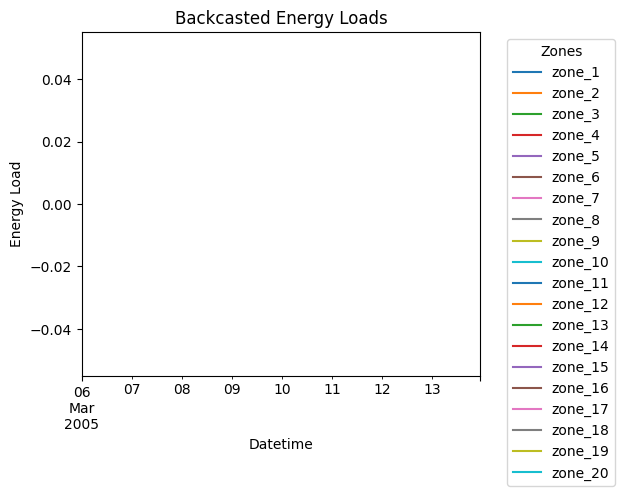

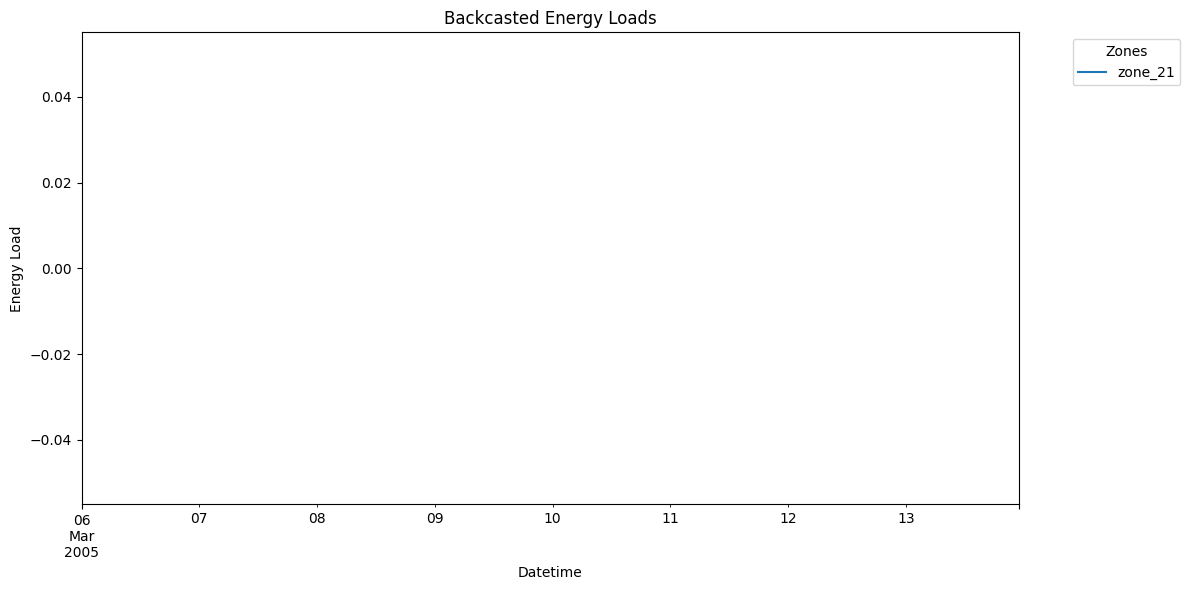

<Figure size 1200x600 with 0 Axes>

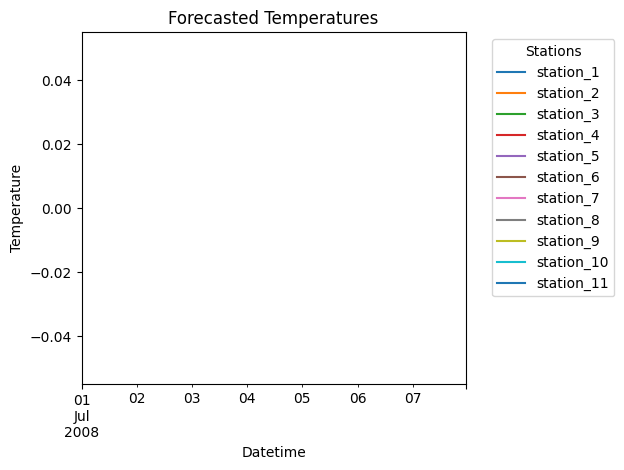

<Figure size 1200x600 with 0 Axes>

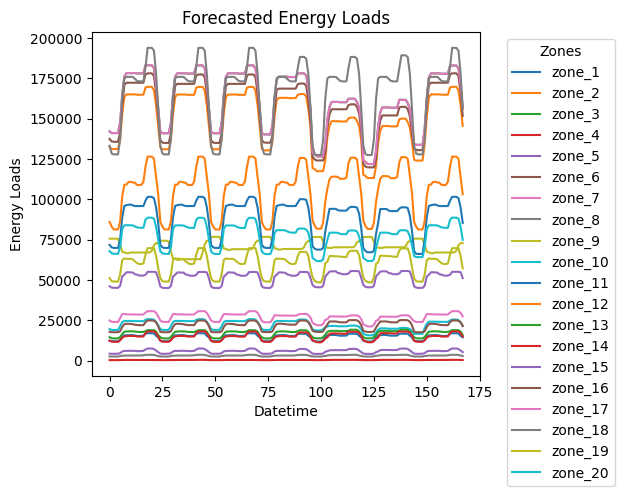

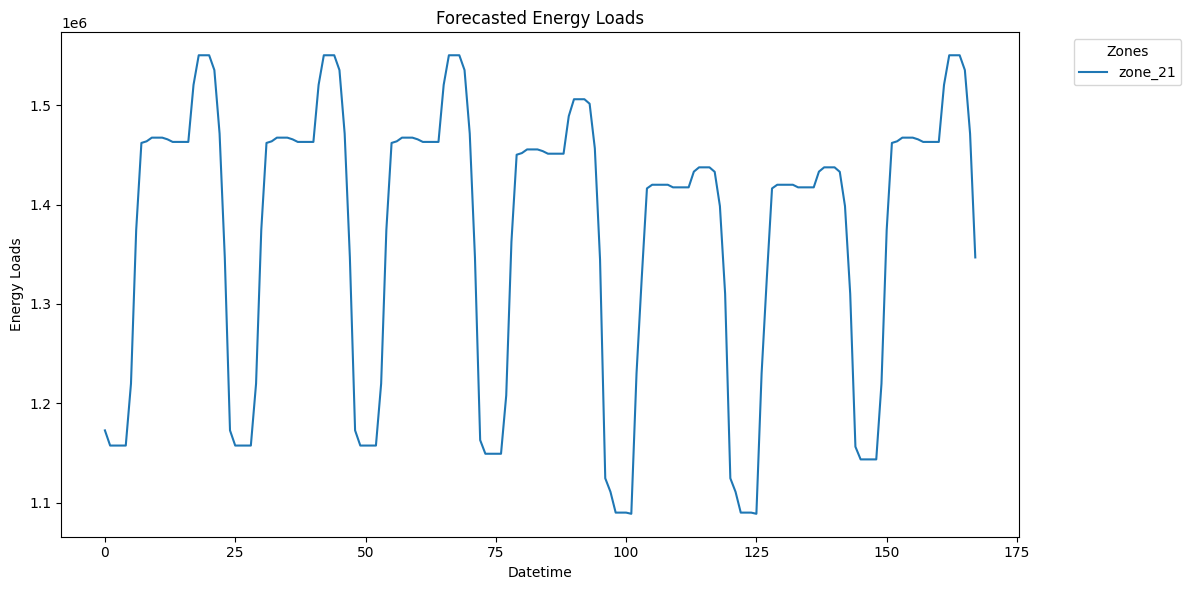

AttributeError: 'DataFrame' object has no attribute 'concat'

In [103]:
# Define the total number of tasks for the progress bar
num_tasks = 1189

# Best parameters for the model
best_backcast_params = {
    'colsample_bytree': 1.0, 
    'gamma': 0, 
    'learning_rate': 0.05, 
    'max_depth': 5, 
    'min_child_weight': 3, 
    'n_estimators': 100, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'subsample': 1.0
}

# Define stations and zones
stations = [f"station_{i}" for i in range(1, 12)]
zones = [f"zone_{i}" for i in range(1, 21)]

# Configuration for engineered features
config = {
    "lag": {col: [1, 2, 3] for col in stations},  # Lags for all station columns
    "rolling_avg": {col: [3, 6, 12] for col in stations},  # Rolling averages
    "add_time_features": True,  # Turn time-based features on/off
}

# Initialize the progress bar
with tqdm(total=num_tasks, desc='Predicting for all zones', colour='rebeccaPurple') as pbar:
    # I: Backcast Loads
    
    # Step 1: Engineering Features
    fixed_set_description(pbar, 'Loading Data')
    d_with_nans = lf.load_all_data(dropna=False)
    pbar.update(32)
    fixed_set_description(pbar, 'Engineering Features')
    d_with_nans = add_engineered_features(d_with_nans, config, pbar=pbar, standardize_columns=stations)
    
    # Step 2: Aggregating Zones
    fixed_set_description(pbar, 'Aggregating Zones')
    d_with_nans['zone_21'] = d_with_nans[zones].sum(axis=1)
    zones.append('zone_21')
    pbar.update(1)

    # Step 3: Slicing Backcast Data
    fixed_set_description(pbar, 'Slicing Backcast Data')
    backcast_data = d_with_nans['2005-03-06':'2005-03-13']
    pbar.update(1)
    for date_range in [
        ('2005-06-20', '2005-06-27'), 
        ('2005-09-10', '2005-09-17'),
        ('2005-12-25', '2006-01-01'),
        ('2006-02-13', '2006-02-20'),
        ('2006-05-25', '2006-06-01'),
        ('2006-08-02', '2006-08-09'),
        ('2006-11-22', '2006-11-29')
    ]:
        backcast_data += d_with_nans[date_range[0]:date_range[1]]
        pbar.update(1)

    # Step 4: Sorting Backcast Data
    fixed_set_description(pbar, 'Sorting Backcast Data')
    backcast_data.drop(columns=zones, inplace=True)
    backcast_data = backcast_data[sorted(backcast_data.columns)]
    pbar.update(1)

    # Initialize storage for backcast loads and scores
    backcast_loads = {}
    scores_rows = []

    # Step 5: Loop through zones and perform backcasting
    for z in range(1, 22):
        zone = f'zone_{z}'
        z_cols = [col for col in zones if col != zone]
        
        # Slicing data for each zone
        fixed_set_description(pbar, f'Prepping {zone}: Slicing Data')
        zone_data = d_with_nans.drop(columns=z_cols, axis=1).copy()
        zone_data = zone_data[sorted(zone_data.columns)]
        pbar.update(1)

        # Splitting Data into features and target
        fixed_set_description(pbar, f'Prepping {zone}: Splitting Data')
        X = zone_data.drop(columns=[zone])
        y = zone_data[zone].astype(float)
        w = weights[zone]
        pbar.update(1)

        # Model training
        model = XGBRegressor(**best_backcast_params)
        cv = ExpandingWindowSplit(n_splits=5)
        
        # Cross-validation loop
        fixed_set_description(pbar, f'Training {zone}')
        rmses, wrmses, maes, mapes = [], [], [], []
        for train_idx, test_idx in cv.split(X, y):
            fixed_set_description(pbar, f'Training {zone}: Fitting')
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pbar.update(1)

            fixed_set_description(pbar, f'Training {zone}: Predicting')
            preds = model.predict(X.iloc[test_idx])
            pbar.update(1)

            fixed_set_description(pbar, f'Training {zone}: Evaluating')
            rmses.append(root_mean_squared_error(y.iloc[test_idx], preds))
            wrmses.append(wrmse(y.iloc[test_idx], preds, w))
            maes.append(mean_absolute_error(y.iloc[test_idx], preds))
            mapes.append(mean_absolute_percentage_error(y.iloc[test_idx], preds))
            pbar.update(1)
        
        # Record the results
        new_row = {
            'zone': zone, 
            'rmse': np.mean(rmses),
            'wrmse': np.mean(wrmses),
            'mae': np.mean(maes),
            'mape': np.mean(mapes)
        }
        scores_rows.append(new_row)

        # Backcasting predictions
        fixed_set_description(pbar, f'Backcasting {zone}')
        backcast_loads[zone] = model.predict(backcast_data)
        pbar.update(1)

        # Print backcasting results
        # print(f'zone_{z:02d}:\tRMSE={new_row["rmse"]:.4f}\tWRMSE={new_row["wrmse"]:.4f}\tMAE={new_row["mae"]:.4f}\tMAPE={new_row["mape"]:.4f}')

    # Step 6: Organizing and outputting backcast scores and predictions
    fixed_set_description(pbar, 'Organizing Backcast Scores')
    backcast_scores = pd.DataFrame(scores_rows)
    pbar.update(1)

    fixed_set_description(pbar, 'Organizing Backcast Values')
    backcast_preds = pd.DataFrame(backcast_loads)
    backcast_preds = backcast_preds.reindex(backcast_data.index)
    pbar.update(1)


    best_forecast_params = best_backcast_params

    # II: Forecast Temps

    temp_cols = stations + ['hour', 'day_of_week', 'month', 'quarter', 'year']

    pbar.set_description('Slicing temperature data')
    temp_data = d_with_nans[temp_cols]
    pbar.update(16)
    pbar.set_description('Sorting temperature data')
    temp_data = temp_data[sorted(temp_data.columns)]
    pbar.update(1)

    pbar.set_description('Constructing forecast data')
    future_datetimes = pd.date_range(start='2008-07-01', periods=168, freq='H')
    forecast_temps_data = pd.DataFrame(index=future_datetimes)
    pbar.update(1)
    forecast_temps_data = add_time_features(forecast_temps_data, pbar)
    forecast_temps_data = forecast_temps_data[sorted(forecast_temps_data.columns)]

    # Initialize storage for backcast loads and scores
    forecast_temps = {}
    scores_rows = []

    for s in range(1,12):
        station = f'station_{s}'
        s_cols = [col for col in stations if col != station]

        # Slicing data for each zone
        fixed_set_description(pbar, f'Prepping {station}: Slicing Data')
        station_data = temp_data.drop(columns=s_cols, axis=1).copy()
        station_data = station_data[sorted(station_data.columns)]
        pbar.update(1)

        # Splitting Data into features and target
        fixed_set_description(pbar, f'Prepping {station}: Splitting Data')
        X = station_data.drop(columns=[station])
        y = station_data[station].astype(float)
        pbar.update(1)

        # Model training
        model = XGBRegressor(**best_forecast_params)
        cv = ExpandingWindowSplit(n_splits=5)

        # Cross-validation loop
        fixed_set_description(pbar, f'Training {station}')
        rmses, maes, mapes = [], [], []
        for train_idx, test_idx in cv.split(X, y):
            fixed_set_description(pbar, f'Training {station}: Fitting')
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pbar.update(1)

            fixed_set_description(pbar, f'Training {station}: Predicting')
            preds = model.predict(X.iloc[test_idx])
            pbar.update(1)

            fixed_set_description(pbar, f'Training {station}: Evaluating')
            rmses.append(root_mean_squared_error(y.iloc[test_idx], preds))
            maes.append(mean_absolute_error(y.iloc[test_idx], preds))
            mapes.append(mean_absolute_percentage_error(y.iloc[test_idx], preds))
            pbar.update(1)
        
        # Record the results
        new_row = {
            'station': station, 
            'rmse': np.mean(rmses),
            'mae': np.mean(maes),
            'mape': np.mean(mapes)
        }
        scores_rows.append(new_row)

        # Backcasting predictions
        fixed_set_description(pbar, f'Forecasting {station}')
        forecast_temps[station] = model.predict(forecast_temps_data)
        pbar.update(1)
    
    # Step 6: Organizing and outputting backcast scores and predictions
    fixed_set_description(pbar, 'Organizing Backcast Scores')
    forecast_temps_scores = pd.DataFrame(scores_rows)
    pbar.update(1)

    fixed_set_description(pbar, 'Organizing Backcast Values')
    temps_preds = pd.DataFrame(forecast_temps)
    temps_preds = temps_preds.reindex(future_datetimes)
    pbar.update(1)

    # III: Forecast Loads

    # Step 3: Slicing Backcast Data
    pbar.set_description('Constructing forecast data')
    forecast_data = pd.DataFrame(index=future_datetimes)
    pbar.update(1)
    for s, vals in temps_preds.items():
        forecast_data[s] = vals
        pbar.update(1)

    forecast_data = add_engineered_features(forecast_data, config, pbar=pbar)

    # Step 4: Sorting Backcast Data
    fixed_set_description(pbar, 'Sorting Forecast Data')
    forecast_data = forecast_data[sorted(forecast_data.columns)]
    pbar.update(1)

    # Initialize storage for backcast loads and scores
    forecast_loads = {}
    scores_rows = []

    # Step 5: Loop through zones and perform backcasting
    for z in range(1, 22):
        zone = f'zone_{z}'
        z_cols = [col for col in zones if col != zone]
        
        # Slicing data for each zone
        fixed_set_description(pbar, f'Prepping {zone}: Slicing Data')
        zone_data = d_with_nans.drop(columns=z_cols, axis=1).copy()
        zone_data = zone_data[sorted(zone_data.columns)]
        pbar.update(1)

        # Splitting Data into features and target
        fixed_set_description(pbar, f'Prepping {zone}: Splitting Data')
        X = zone_data.drop(columns=[zone])
        y = zone_data[zone].astype(float)
        w = weights[zone]
        pbar.update(1)

        # Model training
        model = XGBRegressor(**best_forecast_params)
        cv = ExpandingWindowSplit(n_splits=5)
        
        # Cross-validation loop
        fixed_set_description(pbar, f'Training {zone}')
        rmses, wrmses, maes, mapes = [], [], [], []
        for train_idx, test_idx in cv.split(X, y):
            fixed_set_description(pbar, f'Training {zone}: Fitting')
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pbar.update(1)

            fixed_set_description(pbar, f'Training {zone}: Predicting')
            preds = model.predict(X.iloc[test_idx])
            pbar.update(1)

            fixed_set_description(pbar, f'Training {zone}: Evaluating')
            rmses.append(root_mean_squared_error(y.iloc[test_idx], preds))
            wrmses.append(wrmse(y.iloc[test_idx], preds, w))
            maes.append(mean_absolute_error(y.iloc[test_idx], preds))
            mapes.append(mean_absolute_percentage_error(y.iloc[test_idx], preds))
            pbar.update(1)
        
        # Record the results
        new_row = {
            'zone': zone, 
            'rmse': np.mean(rmses),
            'wrmse': np.mean(wrmses),
            'mae': np.mean(maes),
            'mape': np.mean(mapes)
        }
        scores_rows.append(new_row)

        # Backcasting predictions
        fixed_set_description(pbar, f'Forecasting {zone}')
        forecast_loads[zone] = model.predict(forecast_data)
        pbar.update(1)

        # Print backcasting results
        # print(f'zone_{z:02d}:\tRMSE={new_row["rmse"]:.4f}\tWRMSE={new_row["wrmse"]:.4f}\tMAE={new_row["mae"]:.4f}\tMAPE={new_row["mape"]:.4f}')

    # Step 6: Organizing and outputting backcast scores and predictions
    fixed_set_description(pbar, 'Organizing Forecast Scores')
    forecast_scores = pd.DataFrame(scores_rows)
    pbar.update(1)

    fixed_set_description(pbar, 'Organizing Forecast Values')
    forecast_preds = pd.DataFrame(forecast_loads)
    forecast_preds.reindex(future_datetimes)
    pbar.update(1)

    
    # IV: outputting

    # Step 1: scores
    fixed_set_description(pbar, 'Outputting Scores')
    print(backcast_scores)
    pbar.update(1)
    print(forecast_temps_scores)
    pbar.update(1)
    print(forecast_scores)
    pbar.update(1)

    # Step 2: preds
    # backcast
    fixed_set_description(pbar, 'Plotting Backcasted Energy Loads')
    df_plot = backcast_preds.loc[:, 'zone_1':'zone_20']
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    df_plot.plot()  # This will plot all 21 zones as individual lines
    plt.title('Backcasted Energy Loads')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Energy Load')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()
    pbar.update(1)

    df_plot = backcast_preds.loc[:, 'zone_21']
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    df_plot.plot()  # This will plot all 21 zones as individual lines
    plt.title('Backcasted Energy Loads')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Energy Load')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()
    pbar.update(1)

    # temp forecast
    fixed_set_description(pbar, 'Plotting Forecasted Temperatures')
    df_plot = temps_preds.loc[:, 'station_1':'station_11']
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    df_plot.plot()  # This will plot all 21 zones as individual lines
    plt.title('Forecasted Temperatures')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Temperature')  # Label for the y-axis
    plt.legend(title="Stations", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()
    pbar.update(1)

    # load forecast
    fixed_set_description(pbar, 'Plotting Forecasted Energy Loads')
    df_plot = forecast_preds.loc[:, 'zone_1':'zone_20']
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    df_plot.plot()  # This will plot all 21 zones as individual lines
    plt.title('Forecasted Energy Loads')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Energy Loads')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()
    pbar.update(1)

    df_plot = forecast_preds.loc[:, 'zone_21']
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    df_plot.plot()  # This will plot all 21 zones as individual lines
    plt.title('Forecasted Energy Loads')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Energy Loads')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()
    pbar.update(1)

    fixed_set_description(pbar, 'Finished!')

    total_temp_data = temps_preds.concat(temp_data[stations])
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    total_temp_data.plot()  # This will plot all 21 zones as individual lines
    plt.title('Temperatures Over Time')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Temperature')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()

    total_load_data = d_with_nans.dropna()[zones]
    total_load_data = total_load_data.concat(backcast_preds).concat(forecast_preds)

    zone_load_data = total_load_data[zones].drop(columns=['zone_21'], axis=1)
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    zone_load_data.plot()  # This will plot all 21 zones as individual lines
    plt.title('Energy Loads by Zone Over Time')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Energy Load')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()
    system_load_data = total_load_data['zone_21']
    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    system_load_data.plot()  # This will plot all 21 zones as individual lines
    plt.title('Energy Loads Over Time')  # Title for the plot
    plt.xlabel('Datetime')  # Label for the x-axis
    plt.ylabel('Energy Load')  # Label for the y-axis
    plt.legend(title="Zones", bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement
    plt.tight_layout()  # Adjust the plot to make sure everything fits
    plt.show()

# LSTM stuff

def lstm_cnn_cv(data, sequence_lengths, n_splits=5):
    results = {}

    num_models = len(sequence_lengths)
    with tqdm(total=num_models, desc=f'cv on sequence_lengths: {sequence_lengths}', colour='pink') as pbar1:
        for seq_len in sequence_lengths:
            n = len(data)
            fold_size = n // (n_splits + 1)
            zone = 'zone_1'

            opt_results = []

            with tqdm(total=n_splits, desc=f'Validating {seq_len}', colour='pink') as pbar:
                for i in range(1, n_splits + 1):
                    train_end = i * fold_size
                    test_start = train_end
                    test_end = test_start + fold_size

                    fixed_set_description(pbar, f'Validating [splitting data] {seq_len}')
                    train = data.iloc[:train_end]
                    test = data.iloc[test_start:test_end]

                    # Preprocess the data after splitting (train/test separately)
                    X_train, y_train = train.drop(columns=zone), train[zone]
                    X_test, y_test = test.drop(columns=zone), test[zone]

                    fixed_set_description(pbar, f'Validating [splitting training data] {seq_len}')
                    X_train, y_train = create_sequences(train, seq_len)  # Pass preprocessing params
                    fixed_set_description(pbar, f'Validating [splitting testing data] {seq_len}')
                    X_test, y_test = create_sequences(test, seq_len)

                    fixed_set_description(pbar, f'Validating [training model] {seq_len}')
                    model = lstm_cnn(seq_len, 82)  # Pass model params to the model function
                    model.fit(X_train, y_train, epochs=5, verbose=0)

                    fixed_set_description(pbar, f'Validating [evaluating model] {seq_len}')
                    predictions = model.predict(X_test, verbose=0)
                    rmse = np.sqrt(mean_squared_error(y_test, predictions))
                    opt_results.append(rmse)
                    pbar.update(1)
                results[seq_len] = np.mean(opt_results)
            pbar1.update(1)
        fixed_set_description(pbar, 'Finished!')
    return results

d = dataManager()

results = lstm_cnn_cv(d.out_data(1), [24])

results